In [8]:
from src.utils import *
from src.models.gan import *

import matplotlib.pyplot as plt
import torch
from torch import nn

In [23]:
train_loader, val_loader, test_loader = load_cifar10_dataset(batch_size=128, val_split=0.2)

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [26]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Sigmoid()
  )
)


In [28]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(100, 100, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-03, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-03, betas=(0.5, 0.999))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


In [36]:
for epoch in range(50):
    for i, data in enumerate(train_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device, dtype=torch.float)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, 100, 1, 1, device=device, dtype=torch.float)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, 10, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/10][0/313] Loss_D: 0.0553 Loss_G: 6.3673 D(x): 0.9959 D(G(z)): 0.0400 / 0.0069
[0/10][100/313] Loss_D: 0.0694 Loss_G: 6.7951 D(x): 0.9455 D(G(z)): 0.0081 / 0.0063
[0/10][200/313] Loss_D: 0.3448 Loss_G: 11.0437 D(x): 0.9955 D(G(z)): 0.1943 / 0.0001
[0/10][300/313] Loss_D: 0.0156 Loss_G: 6.8080 D(x): 0.9995 D(G(z)): 0.0137 / 0.0044
[1/10][0/313] Loss_D: 0.0833 Loss_G: 7.0576 D(x): 0.9928 D(G(z)): 0.0461 / 0.0033
[1/10][100/313] Loss_D: 0.0337 Loss_G: 8.5979 D(x): 0.9867 D(G(z)): 0.0071 / 0.0017
[1/10][200/313] Loss_D: 0.0368 Loss_G: 7.5264 D(x): 0.9885 D(G(z)): 0.0208 / 0.0031
[1/10][300/313] Loss_D: 0.0747 Loss_G: 6.8726 D(x): 0.9984 D(G(z)): 0.0553 / 0.0032
[2/10][0/313] Loss_D: 0.0214 Loss_G: 7.7317 D(x): 0.9956 D(G(z)): 0.0099 / 0.0078
[2/10][100/313] Loss_D: 0.3154 Loss_G: 8.3566 D(x): 0.9974 D(G(z)): 0.1816 / 0.0013
[2/10][200/313] Loss_D: 0.0841 Loss_G: 6.1275 D(x): 0.9903 D(G(z)): 0.0604 / 0.0091
[2/10][300/313] Loss_D: 0.0938 Loss_G: 7.9810 D(x): 0.9887 D(G(z)): 0.0564 / 0.00

In [33]:
def sample(model, num_samples, device='cpu', show=False):
    with torch.no_grad():
        z = torch.randn(num_samples, 100, 1, 1, device=device)
        samples = model(z)

    num_rows = num_samples // 10

    if show:
        fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
        for j in range(num_rows):
            for i in range(10):
                axes[j, i].imshow(samples[j * 10 + i].permute(1, 2, 0).cpu().numpy())
                axes[j, i].axis("off")
        plt.tight_layout()
        plt.show()

    return samples

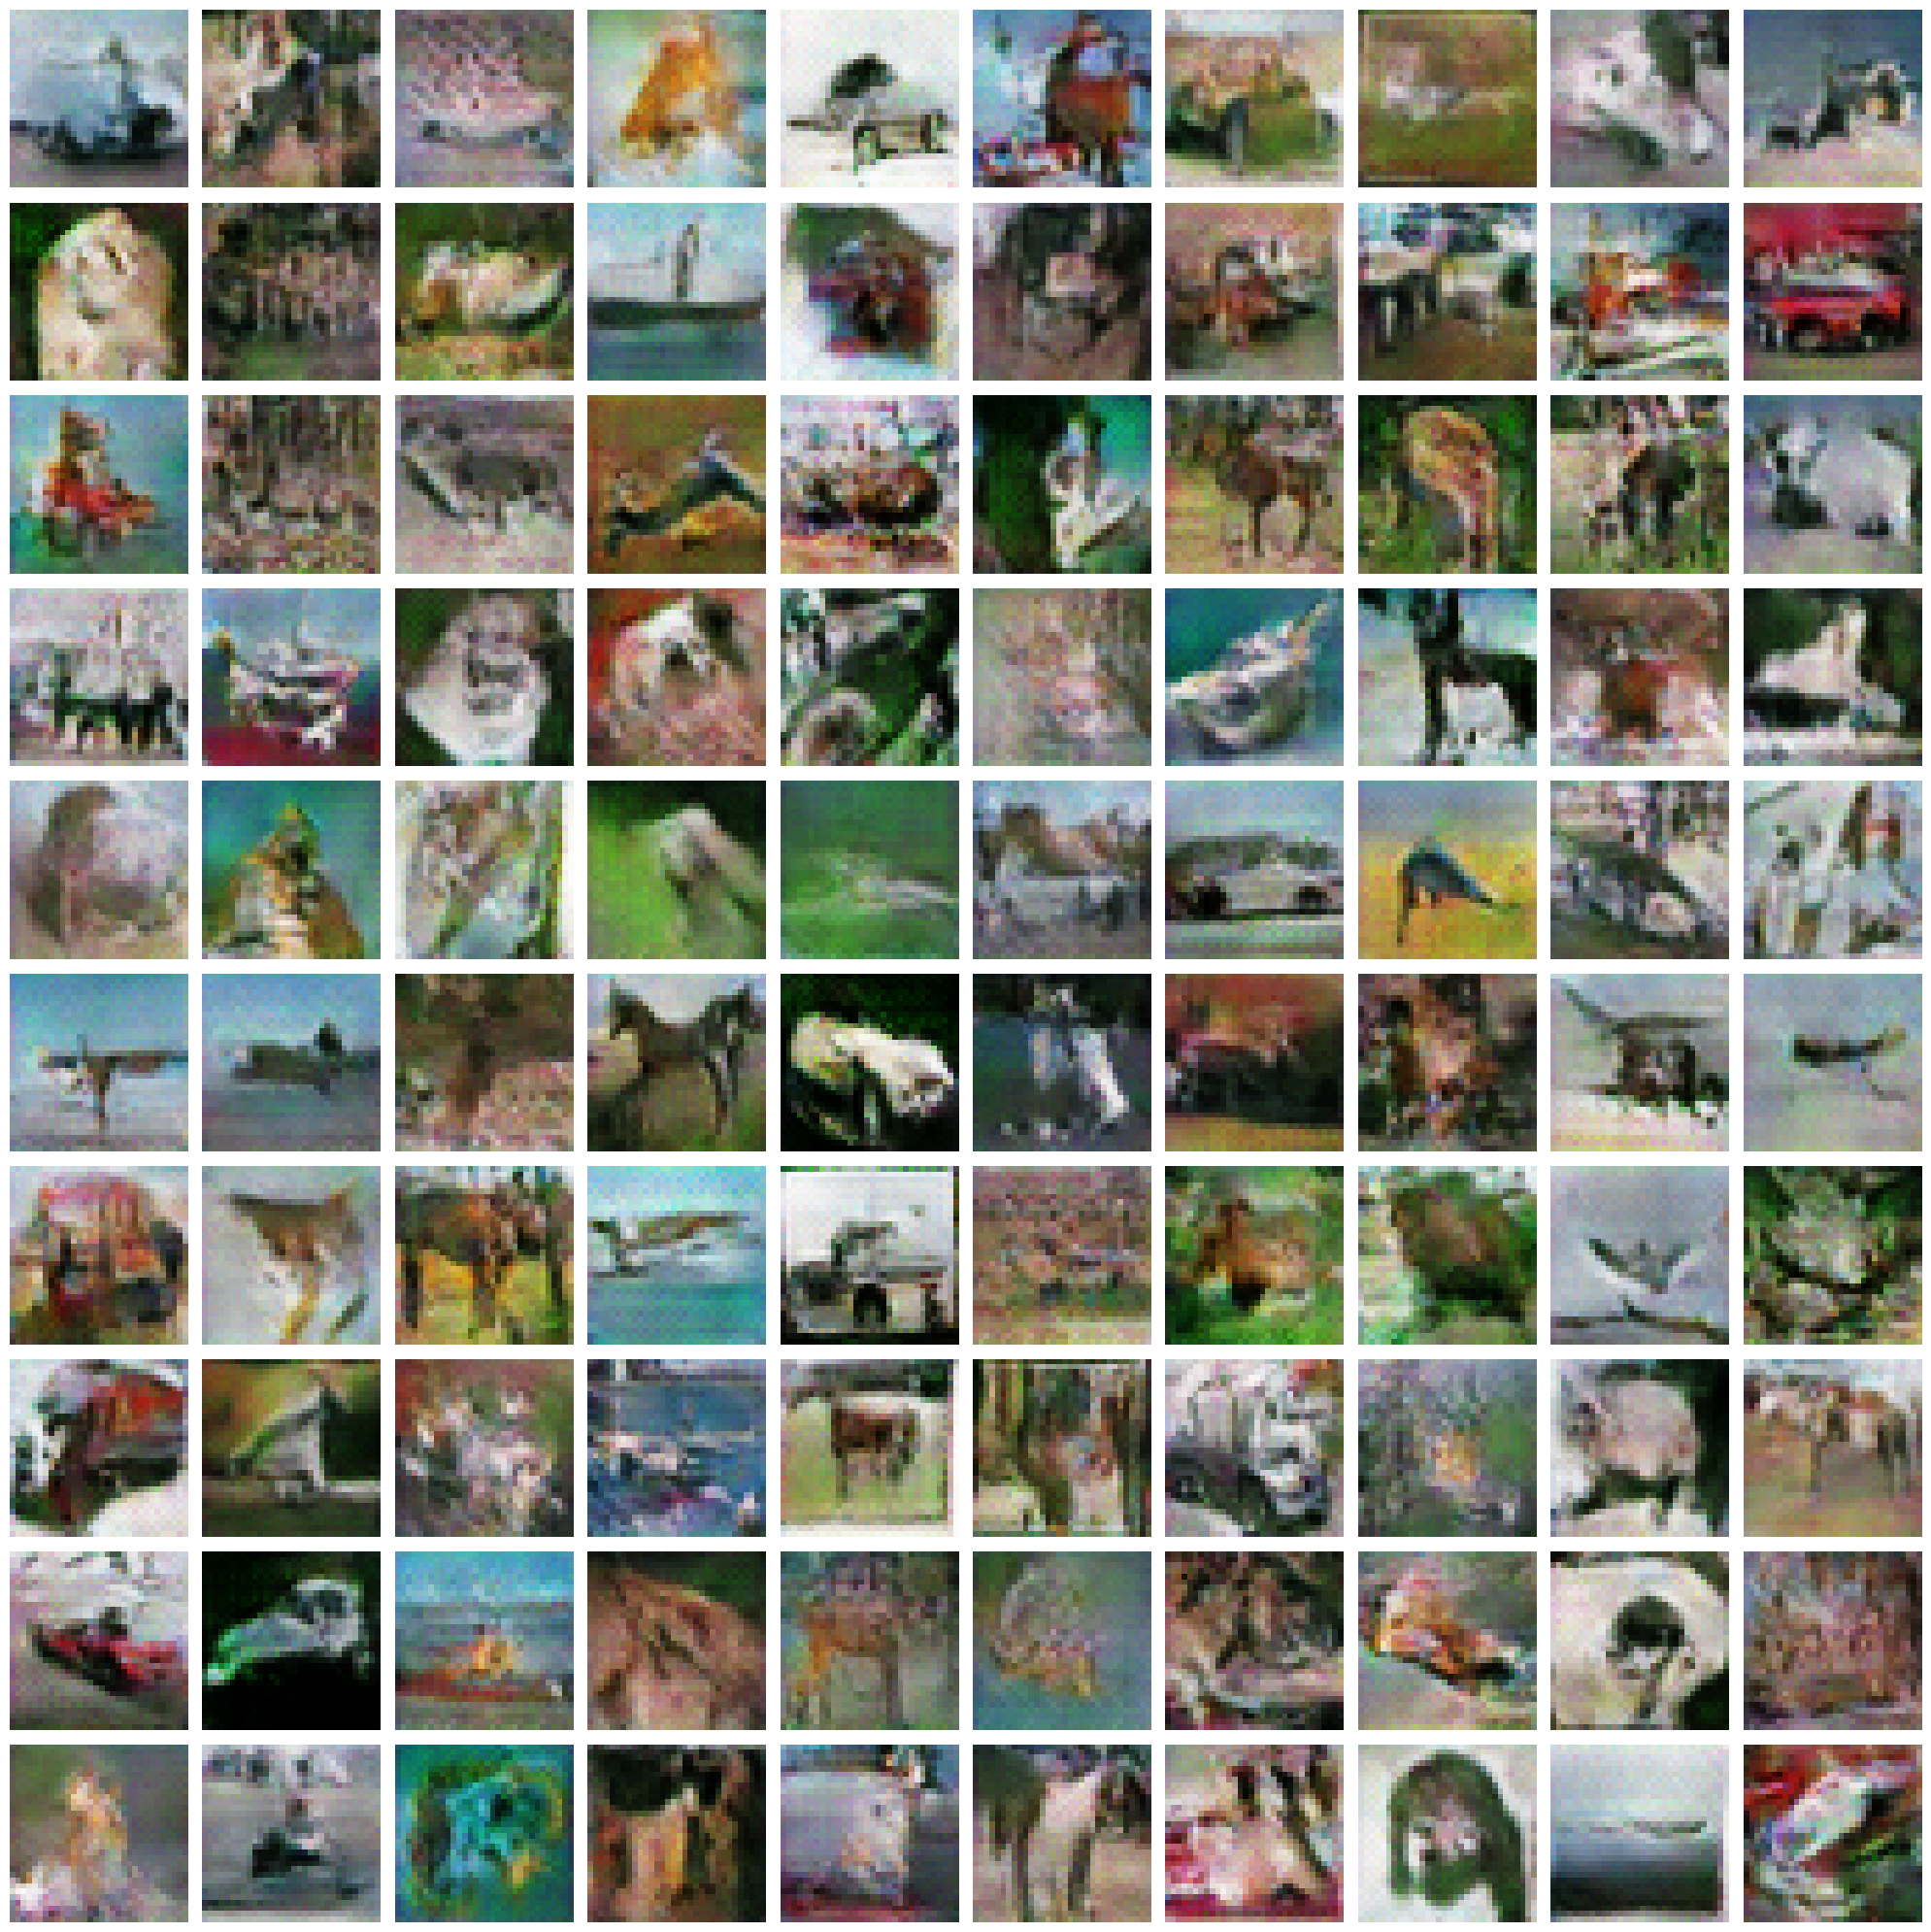

In [35]:
sample(netG, 100, device=device, show=True)
pass

In [ ]:
def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Optimizers
        optimizer_g = optimizers["generator"]
        optimizer_d = optimizers["discriminator"]

        # Train generator
        z = torch.randn(imgs.shape[0], self.latent_dim, 1, 1, device=self.device, dtype=torch.float)
        valid = torch.ones(imgs.size(0), device=self.device)

        generated_imgs = self.generator(z)
        g_loss = self.adversarial_loss(self.discriminator(generated_imgs), valid)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # Train discriminator
        valid = torch.ones(imgs.size(0), device=self.device)
        fake = torch.zeros(imgs.size(0), device=self.device)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        return {"g_loss": g_loss.item(), "d_loss": d_loss.item()}